# HeadDiffLineSink1D and FluxDiffLineSink1D

Continuity of head and continuity of flow.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timml

import ttim

plt.rcParams["figure.figsize"] = (10, 4)

## Single layer

In [2]:
k = 10.0
H = 10.0
S = 0.2

delh = 2.0
t0 = 0.0

In [3]:
mlconf = ttim.ModelMaq(
    kaq=k, z=[0, -H], Saq=S, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls_left = ttim.HeadLineSink1D(mlconf, xls=0.0, tsandh=[(0, delh)], layers=[0])
hls_right = ttim.HeadLineSink1D(mlconf, xls=200.0, tsandh=[(0, 0.0)], layers=[0])

# headdiff on right side, fluxdiff on left side
hdiff = ttim.HeadDiffLineSink1D(mlconf, xls=100.0 + 1e-12, layers=[0])
qdiff = ttim.FluxDiffLineSink1D(mlconf, xls=100.0 - 1e-12, layers=[0])

mlconf.solve()

self.neq  2
solution complete


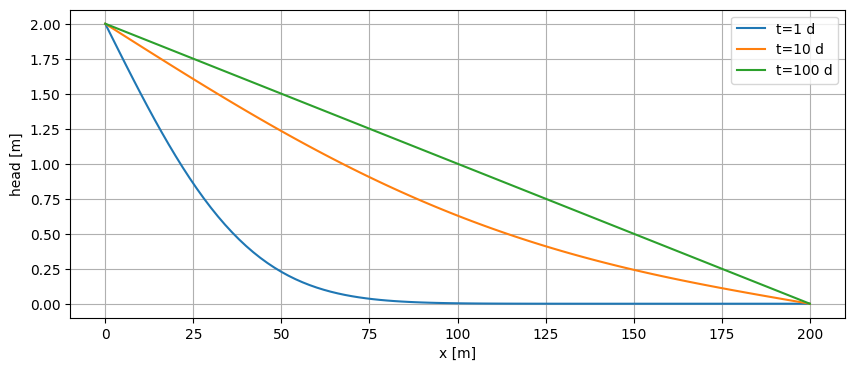

In [4]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.0f} d")

plt.legend()
plt.xlabel("x [m]")
plt.ylabel("head [m]")
plt.grid()

## Multi-aquifer cross-sections

In [5]:
z = [0.0, -5.0, -6.0, -15.0]
Saq = [0.2, 1e-4]
c = [10.0]
k = np.array([5.0, 10.0])
k_left = 0.5 * k
k_right = k
delh = 1.0
res = 10.0

Transient model

In [6]:
mlconf2 = ttim.ModelXsection(naq=2, tmin=1, tmax=1e2)
inhom_left = ttim.XsectionMaq(
    mlconf2,
    -np.inf,
    100.0,
    kaq=k_left,
    z=z,
    Saq=Saq,
    c=c,
    topboundary="conf",
    phreatictop=True,
)
inhom_right = ttim.XsectionMaq(
    mlconf2,
    100.0,
    np.inf,
    kaq=k_right,
    z=z,
    Saq=Saq,
    c=c,
    topboundary="conf",
    phreatictop=True,
)

hls_left = ttim.HeadLineSink1D(mlconf2, xls=0.0, tsandh=[(0, delh)], layers=[0, 1])
hls_right = ttim.HeadLineSink1D(mlconf2, xls=200.0, tsandh=[(0, 0.0)], layers=[0, 1])

mlconf2.solve()

self.neq  8
solution complete


Steady-state model.

In [7]:
mlss = timml.ModelMaq(kaq=k, z=z, c=c, topboundary="conf")
inhom_left = timml.StripInhomMaq(
    mlss,
    -np.inf,
    100.0,
    kaq=k_left,
    z=z,
    c=c,
    topboundary="conf",
)
inhom_right = timml.StripInhomMaq(
    mlss,
    100.0,
    np.inf,
    kaq=k_right,
    z=z,
    c=c,
    topboundary="conf",
)

hls_left = timml.HeadLineSink1D(mlss, xls=0.0, hls=1.0, layers=[0, 1])
hls_right = timml.HeadLineSink1D(mlss, xls=200.0, hls=0.0, layers=[0, 1])

mlss.solve()

Number of elements, Number of equations: 4 , 8
....
solution complete


/tmp/ipykernel_8171/3950894639.py:2: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_left = timml.StripInhomMaq(
/tmp/ipykernel_8171/3950894639.py:11: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_right = timml.StripInhomMaq(


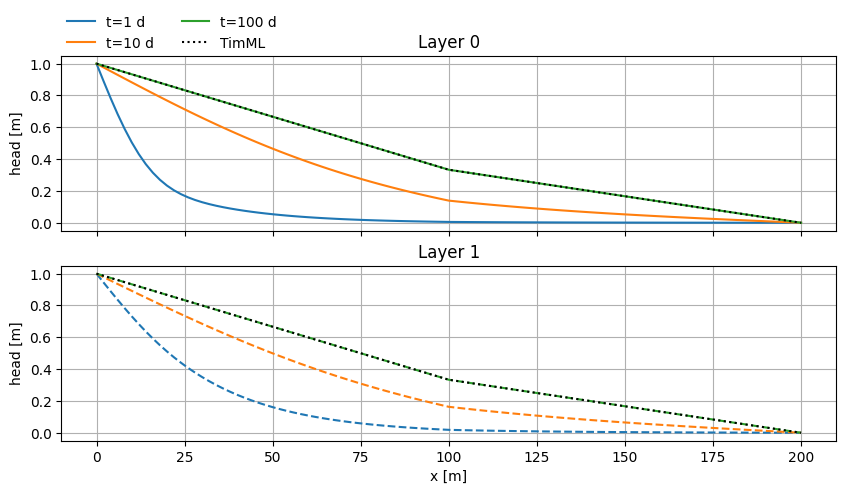

In [8]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 5))

for i in range(len(t)):
    h = mlconf2.headalongline(x, y, t[i])
    ax0.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d")
    ax1.plot(x, h[1].squeeze(), label=f"t={t[i]:.0f} d", ls="dashed")

hss = mlss.headalongline(x, y)
ax0.plot(x, hss[0].squeeze(), lw=1.5, color="k", ls="dotted", label="TimML")
ax1.plot(x, hss[1].squeeze(), lw=1.5, color="k", ls="dotted")

ax0.legend(loc=(0, 1), frameon=False, ncol=2)
ax0.set_title("Layer 0")
ax1.set_xlabel("x [m]")
ax1.set_title("Layer 1")
for ax in [ax0, ax1]:
    ax.set_ylabel("head [m]")
    ax.grid()

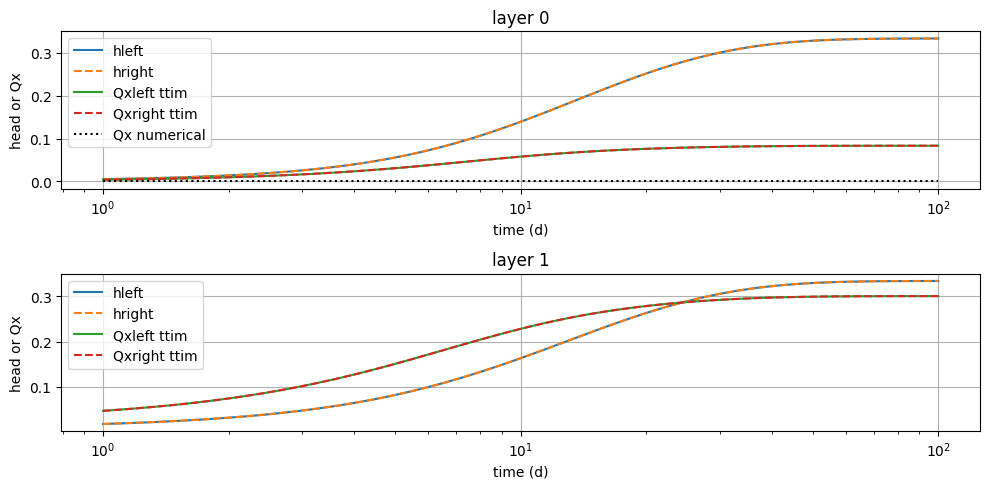

In [9]:
dx = 1e-6
t = np.logspace(0, 2, 100)
hleft = mlconf2.head(100 - dx, 0, t)
hright = mlconf2.head(100 + dx, 0, t)
disxleft, _ = mlconf2.disvec(100 - dx, 0, t)
disxright, _ = mlconf2.disvec(100 + dx, 0, t)
disxnum = inhom_left.Haq[:, np.newaxis] * (hleft - hright) / res

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.semilogx(t, hleft[i], label="hleft")
    plt.semilogx(t, hright[i], "--", label="hright")
    plt.semilogx(t, disxleft[i], label="Qxleft ttim")
    plt.semilogx(t, disxright[i], "--", label="Qxright ttim")
    if i == 0:  # otherwise no leaky wall
        plt.semilogx(t, disxnum[i], "k:", label="Qx numerical")
    plt.xlabel("time (d)")
    plt.ylabel("head or Qx")
    plt.title(f"layer {i}")
    plt.legend()
    plt.grid()
plt.tight_layout()

## 3 strip inhomogeneities

Test if 3 strip inhomogeneities are working. Introduce a middle inhom with hydraulic conductivity $2k$.

In [10]:
k_mid = [2 * k]

mlconf2 = ttim.ModelXsection(naq=2, tmin=1, tmax=1e2)

inhom_left = ttim.XsectionMaq(
    mlconf2,
    -np.inf,
    50.0,
    kaq=k_left,
    z=z,
    Saq=Saq,
    c=c,
    topboundary="conf",
    phreatictop=True,
)
inhom_mid = ttim.XsectionMaq(
    mlconf2,
    50,
    150.0,
    kaq=2 * k,
    z=z,
    Saq=Saq,
    c=c,
    topboundary="conf",
    phreatictop=True,
)
inhom_right = ttim.XsectionMaq(
    mlconf2,
    150.0,
    np.inf,
    kaq=k_right,
    z=z,
    Saq=Saq,
    c=c,
    topboundary="conf",
    phreatictop=True,
)

hls_left = ttim.HeadLineSink1D(mlconf2, xls=0.0, tsandh=[(0, delh)], layers=[0, 1])
hls_right = ttim.HeadLineSink1D(mlconf2, xls=200.0, tsandh=[(0, 0.0)], layers=[0, 1])

mlconf2.solve()

self.neq  12
solution complete


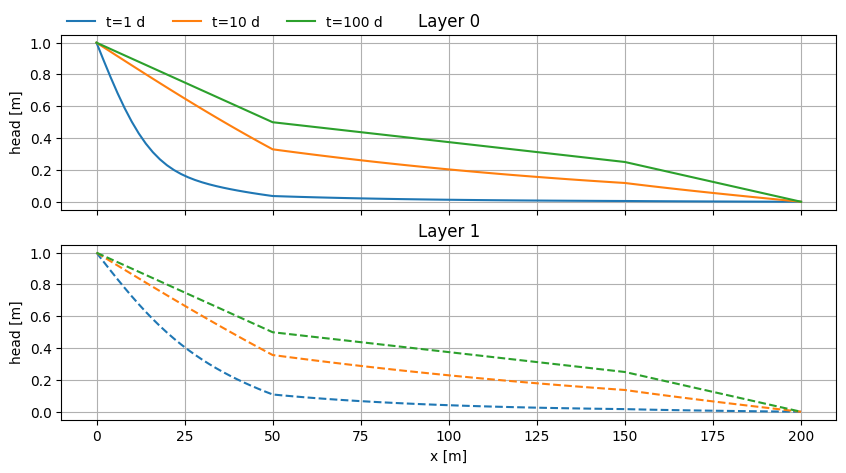

In [11]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 5))

for i in range(len(t)):
    h = mlconf2.headalongline(x, y, t[i])
    ax0.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d")
    ax1.plot(x, h[1].squeeze(), label=f"t={t[i]:.0f} d", ls="dashed")

ax0.legend(loc=(0, 1), frameon=False, ncol=3)
ax0.set_title("Layer 0")
ax1.set_xlabel("x [m]")
ax1.set_title("Layer 1")
for ax in [ax0, ax1]:
    ax.set_ylabel("head [m]")
    ax.grid()

## Infiltration between two rivers

Problem from Ch. 5 Analytical Groundwater Modeling: Theory and Applications Using Python (Bakker & Post, 2022)

In [12]:
k = [20.0]
H = 10.0
Saq = [0.1]
L = 1000.0
N = 1e-3
z = [0, -H]

In [13]:
mlconf = ttim.ModelXsection(naq=1, tmin=1, tmax=1e3)

left = ttim.XsectionMaq(
    mlconf,
    -np.inf,
    -L / 2,
    kaq=k,
    z=z,
    Saq=Saq,
    # c=c,
    topboundary="conf",
    phreatictop=True,
)
inf = ttim.XsectionMaq(
    mlconf,
    -L / 2,
    L / 2,
    kaq=k,
    z=z,
    Saq=Saq,
    # c=c,
    topboundary="conf",
    phreatictop=True,
    tsandN=[(0.0, N)],
)
right = ttim.XsectionMaq(
    mlconf,
    L / 2,
    np.inf,
    kaq=k,
    z=z,
    Saq=Saq,
    # c=c,
    topboundary="conf",
    phreatictop=True,
)

d = -1e-3
hls_left = ttim.HeadLineSink1D(mlconf, xls=-L / 2 + d, tsandh=[(0, 0.0)], layers=[0])
hls_right = ttim.HeadLineSink1D(mlconf, xls=L / 2 - d, tsandh=[(0, 0.0)], layers=[0])

mlconf.solve()

self.neq  6
solution complete


In [14]:
mlss = timml.ModelMaq(kaq=k, z=z, c=c, topboundary="conf")

inhom_left = timml.StripInhomMaq(
    mlss,
    -np.inf,
    -L / 2,
    kaq=k,
    z=z,
    c=c,
    topboundary="conf",
)
inhom_mid = timml.StripInhomMaq(
    mlss,
    -L / 2,
    L / 2,
    kaq=k,
    z=z,
    c=c,
    topboundary="conf",
    N=N,
)

inhom_right = timml.StripInhomMaq(
    mlss,
    L / 2,
    np.inf,
    kaq=k,
    z=z,
    c=c,
    topboundary="conf",
)

hls_left = timml.HeadLineSink1D(mlss, xls=-L / 2 + d, hls=0.0, layers=[0])
hls_right = timml.HeadLineSink1D(mlss, xls=L / 2 - d, hls=0.0, layers=[0])

mlss.solve()

Number of elements, Number of equations: 7 , 6
.......
solution complete


/tmp/ipykernel_8171/1415080540.py:3: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_left = timml.StripInhomMaq(
/tmp/ipykernel_8171/1415080540.py:12: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_mid = timml.StripInhomMaq(
/tmp/ipykernel_8171/1415080540.py:23: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_right = timml.StripInhomMaq(


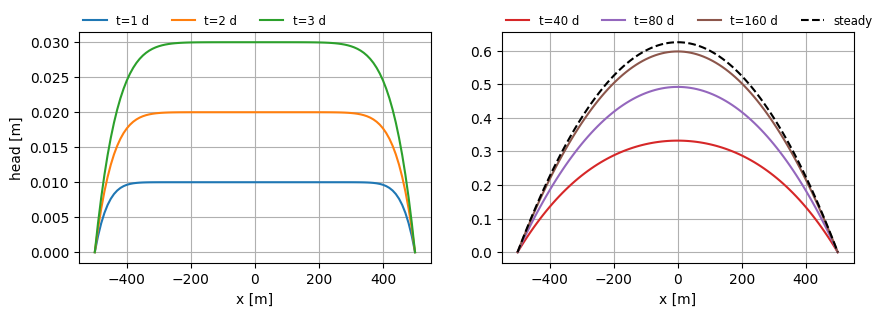

In [15]:
x = np.linspace(-L / 2 + 1e-5, L / 2 - 1e-5, 101)
y = np.zeros_like(x)
t = [1, 2, 3]

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 3))

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    ax0.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d")

t = [40, 80, 160]
for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    ax1.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d", color=f"C{i + 3}")

hss = mlss.headalongline(x, y)
ax1.plot(x, hss[0].squeeze(), color="k", ls="dashed", label="steady")

ax0.legend(loc=(0, 1), frameon=False, ncol=3, fontsize="small")
ax1.legend(loc=(0, 1), frameon=False, ncol=4, fontsize="small")
ax0.set_ylabel("head [m]")
for ax in [ax0, ax1]:
    ax.set_xlabel("x [m]")
    ax.grid()

## Change in waterlevel

In [16]:
k = [10.0]
H = 10.0
z = [1.0, 0, -H]
S = [1e-2]
c = [100.0]
delh = 2.0

In [17]:
mlsemi = ttim.ModelXsection(naq=1, tmin=1, tmax=1e2)

inhom_left = ttim.XsectionMaq(
    mlsemi,
    -np.inf,
    0.0,
    kaq=k,
    Saq=Saq,
    z=z,
    c=c,
    topboundary="semi",
    phreatictop=False,
    tsandhstar=[(0.0, delh)],
)
inhom_right = ttim.XsectionMaq(
    mlsemi,
    0.0,
    np.inf,
    kaq=k,
    Saq=Saq,
    z=z,
    c=c,
    topboundary="semi",
    phreatictop=False,
    tsandhstar=[(0.0, 0.0)],
)

# hls_right = ttim.HeadLineSink1D(mlsemi, xls=300, tsandh=[(0, 0.0)], layers=[0])

mlsemi.solve()

self.neq  2
solution complete


In [18]:
mlss = timml.ModelMaq(
    kaq=k,
    z=z,
    c=c,
    topboundary="semi",
    hstar=0.0,
)

inhom_left_ss = timml.StripInhomMaq(
    mlss,
    -np.inf,
    0.0,
    kaq=k,
    z=z,
    c=c,
    topboundary="semi",
    hstar=delh,
)
inhom_right_ss = timml.StripInhomMaq(
    mlss,
    0.0,
    np.inf,
    kaq=k,
    z=z,
    c=c,
    topboundary="semi",
    hstar=0.0,
)
mlss.solve()

Number of elements, Number of equations: 5 , 2
.....
solution complete


/tmp/ipykernel_8171/3998786092.py:9: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_left_ss = timml.StripInhomMaq(
/tmp/ipykernel_8171/3998786092.py:19: DeprecationWarning: 'StripInhomMaq' is deprecated and has been renamed to 'XsectionMaq'
  inhom_right_ss = timml.StripInhomMaq(


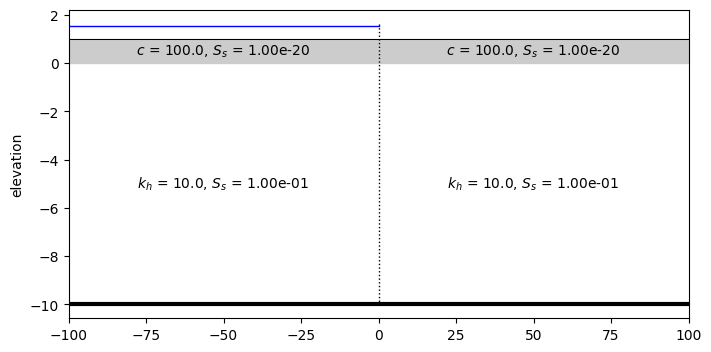

In [19]:
lab = np.sqrt(k[0] * H * c[0])
L = 2 * 3 * lab
ax = inhom_left.plot(params=True)
ax = inhom_right.plot(ax=ax, params=True)
mlsemi.elementlist[0].plot(ax=ax)
ax.set_xlim(-100, 100);

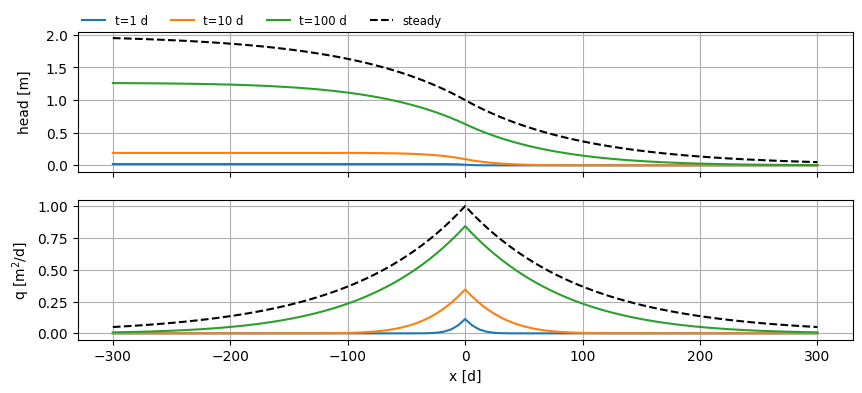

In [20]:
x = np.linspace(-L / 2, L / 2, 101)
y = np.zeros_like(x)
t = [1, 10, 100]

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(10, 4))

h = mlsemi.headalongline(x, y, t)
q = np.zeros_like(h)
for i in range(len(x)):
    q[:, :, i] = mlsemi.disvec(x[i], y[i], t)[0]
for i in range(len(t)):
    ax0.plot(x, h[0, i].squeeze(), label=f"t={t[i]:.0f} d")
    ax1.plot(x, q[0, i].squeeze(), label=f"t={t[i]:.0f} d")

hss = mlss.headalongline(x, y)
qss = mlss.disvecalongline(x, y)
ax0.plot(x, hss[0].squeeze(), color="k", ls="dashed", label="steady")
ax1.plot(x, qss[0].squeeze(), color="k", ls="dashed", label="steady")

ax0.legend(loc=(0, 1), frameon=False, ncol=4, fontsize="small")
ax0.set_ylabel("head [m]")
ax1.set_xlabel("x [d]")
ax1.set_ylabel("q [m$^2$/d]")
for ax in [ax0, ax1]:
    ax.grid()
fig.align_ylabels()